In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from salishsea_tools import viz_tools, places, visualisations
from matplotlib import pyplot as plt, dates
from datetime import datetime, timedelta
from calendar import month_name
from scipy.io import loadmat
from tqdm.notebook import tqdm
from salishsea_tools import nc_tools
from dask.diagnostics import ProgressBar
import cmocean
import arrow

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

In [3]:
# Load monthly averages
mask = xr.open_dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/mesh_mask202108.nc')
slc = {'y': slice(0,898), 'x': slice(0,398)} #coordinates for 201905 are y and x
e3t, tmask = [mask[var].isel(z=slice(20, 40),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2007, 2023), ['nitrate']


# Temporary list dict
data = {}

# Permanent aggregate dict
aggregates = {var: {} for var in variables}

slc = {'gridY': slice(0,898), 'gridX': slice(0,398)} #redefine with gridY and gridX for biol dataset because there are new coordinate names for 202111 model run

# Loop through years
for year in years:
    jan = arrow.get(f"{year}-01-01")
    dec = arrow.get(f"{year}-12-01")
    
    for var in variables: 
        data[var] = []
    # Load monthly averages 
    months = arrow.Arrow.range("month", jan, dec)
    for month in months:
        yyyymmdd_first = month.format("YYYYMMDD")
        yyyymmdd_last = month.shift(months=+1).shift(days=-1).format("YYYYMMDD")
        ds_file = f"/results2/SalishSea/month-avg.202111/SalishSeaCast_1m_biol_T_{yyyymmdd_first}_{yyyymmdd_last}.nc"
   
        
    
        # Load variables
        with xr.open_dataset(ds_file) as ds:
            for var in ['nitrate']:
                #data[var].append(ds.nitrate.isel(depth=0, **slc).values)
                data[var].append((ds[var].isel(depth=slice(20, 40),**slc)*e3t*tmask).sum(axis=1)/((e3t*tmask).sum(axis=1)).data)
    
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)
        


# Calculate climatological mean and anomalies
for var in variables:
    aggregates[var]['mean'] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
    for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var]['mean']

In [4]:
print(np.shape(aggregates['nitrate'][2015][:]))

(898, 398)


In [5]:
# Reset variables for plotting
tmask = tmask[0, 0, ...]
variables = ['nitrate']

In [6]:
np.ma.masked_where(tmask==0,((aggregates['nitrate']['mean']))).max()

34.62246039707194

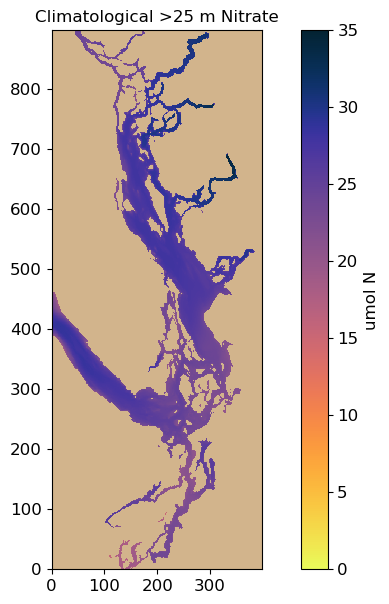

In [11]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')
vmin=0
vmax=35
cmap1=cmocean.cm.thermal_r
cmap1.set_bad('tan')
il=0

fig,ax=plt.subplots(1,1,figsize=(10,7))
#fig.suptitle('Annual Anomalies Mesozoop Feeding on Diatoms', fontsize=16)
m0=ax.pcolormesh(np.ma.masked_where(tmask==0,((aggregates['nitrate']['mean']))),cmap=cmap1,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax,coords='grid')
ax.set_title('Climatological >25 m Nitrate')
fig.colorbar(m0,ax=ax,label='umol N')

#ax.plot(259,104,'*',color='red',markersize=10)
#ax.plot(81,329,'*',color='red',markersize=10)# move around the i,j coordinates of the red dot til it is where you want
#ax.plot(258,450,'*',color='red',markersize=10)# move around the i,j coordinates of the red dot til it is where you want



In [8]:
np.shape(data['nitrate'])

(12, 1, 898, 398)

In [9]:
np.ma.masked_where(tmask==0,((data['nitrate'][11][0])))

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

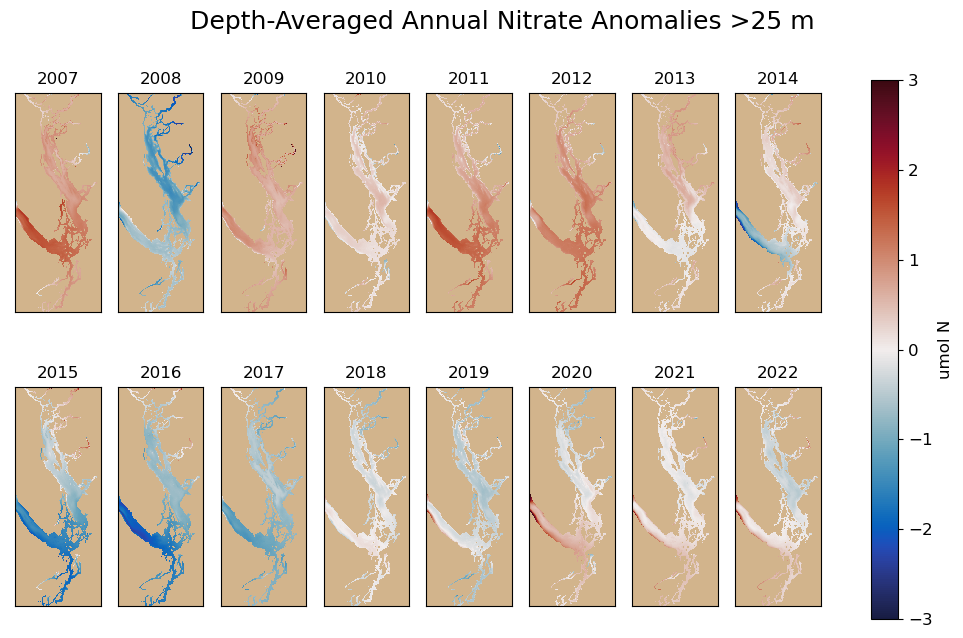

In [13]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')

#cmap1=cmocean.cm.haline
#cmap1.set_bad('k')
il=0
vmin=-3
vmax=3

fig,ax=plt.subplots(2,8,figsize=(13,7))
fig.suptitle('Depth-Averaged Annual Nitrate Anomalies >25 m', fontsize=18)


m0=ax[0,0].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['nitrate'][2007]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,0],coords='grid')
ax[0,0].set_title('2007')
ax[0,0].yaxis.set_visible(False)
ax[0,0].xaxis.set_visible(False)
ax[0,0].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[1])

m0=ax[0,1].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['nitrate'][2008]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,1],coords='grid')
ax[0,1].set_title('2008')
ax[0,1].yaxis.set_visible(False)
ax[0,1].xaxis.set_visible(False)
ax[0,1].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[2])

m0=ax[0,2].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['nitrate'][2009]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,2],coords='grid')
ax[0,2].set_title('2009')
ax[0,2].yaxis.set_visible(False)
ax[0,2].xaxis.set_visible(False)
ax[0,2].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[3])

m0=ax[0,3].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['nitrate'][2010]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,3],coords='grid')
ax[0,3].set_title('2010')
ax[0,3].yaxis.set_visible(False)
ax[0,3].xaxis.set_visible(False)
ax[0,3].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[4])

m0=ax[0,4].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['nitrate'][2011]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,4],coords='grid')
ax[0,4].set_title('2011')
ax[0,4].yaxis.set_visible(False)
ax[0,4].xaxis.set_visible(False)
ax[0,4].yaxis.set_visible(False)

m0=ax[0,5].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['nitrate'][2012]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,5],coords='grid')
ax[0,5].set_title('2012')
ax[0,5].yaxis.set_visible(False)
ax[0,5].xaxis.set_visible(False)
ax[0,5].yaxis.set_visible(False)

m0=ax[0,6].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['nitrate'][2013]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,6],coords='grid')
ax[0,6].set_title('2013')
ax[0,6].yaxis.set_visible(False)
ax[0,6].xaxis.set_visible(False)
ax[0,6].yaxis.set_visible(False)

m0=ax[0,7].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['nitrate'][2014]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,7],coords='grid')
ax[0,7].set_title('2014')
ax[0,7].yaxis.set_visible(False)
ax[0,7].xaxis.set_visible(False)
ax[0,7].yaxis.set_visible(False)

m0=ax[1,0].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['nitrate'][2015]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,0],coords='grid')
ax[1,0].set_title('2015')
ax[1,0].yaxis.set_visible(False)
ax[1,0].xaxis.set_visible(False)
ax[1,0].yaxis.set_visible(False)

m0=ax[1,1].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['nitrate'][2016]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,1],coords='grid')
ax[1,1].set_title('2016')
ax[1,1].yaxis.set_visible(False)
ax[1,1].xaxis.set_visible(False)
ax[1,1].yaxis.set_visible(False)

m0=ax[1,2].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['nitrate'][2017]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,2],coords='grid')
ax[1,2].set_title('2017')
ax[1,2].yaxis.set_visible(False)
ax[1,2].xaxis.set_visible(False)
ax[1,2].yaxis.set_visible(False)

m0=ax[1,3].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['nitrate'][2018]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,3],coords='grid')
ax[1,3].set_title('2018')
ax[1,3].yaxis.set_visible(False)
ax[1,3].xaxis.set_visible(False)
ax[1,3].yaxis.set_visible(False)

m0=ax[1,4].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['nitrate'][2019]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,4],coords='grid')
ax[1,4].set_title('2019')
ax[1,4].yaxis.set_visible(False)
ax[1,4].xaxis.set_visible(False)
ax[1,4].yaxis.set_visible(False)

m0=ax[1,5].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['nitrate'][2020]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,5],coords='grid')
ax[1,5].set_title('2020')
ax[1,5].yaxis.set_visible(False)
ax[1,5].xaxis.set_visible(False)
ax[1,5].yaxis.set_visible(False)

m0=ax[1,6].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['nitrate'][2021]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,6],coords='grid')
ax[1,6].set_title('2021')
ax[1,6].yaxis.set_visible(False)
ax[1,6].xaxis.set_visible(False)
ax[1,6].yaxis.set_visible(False)

m0=ax[1,7].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['nitrate'][2022]))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,7],coords='grid')
ax[1,7].set_title('2022')
ax[1,7].yaxis.set_visible(False)
ax[1,7].xaxis.set_visible(False)
ax[1,7].yaxis.set_visible(False)

fig.colorbar(m0,ax=ax,label='umol N')

